In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
import time
import torch
import kornia
import kornia.filters as filters

In [2]:
image = cv.cvtColor(cv.imread('bowl-of-fruit.jpg').astype(np.float32) / 255, cv.COLOR_BGR2RGB)
image2 = cv.cvtColor(cv.imread('yeah.jpg').astype(np.float32) / 255, cv.COLOR_BGR2RGB)
seam_image = cv2.cvtColor(cv2.imread('york.jpg').astype(np.float32)/255.0, cv2.COLOR_BGR2RGB)

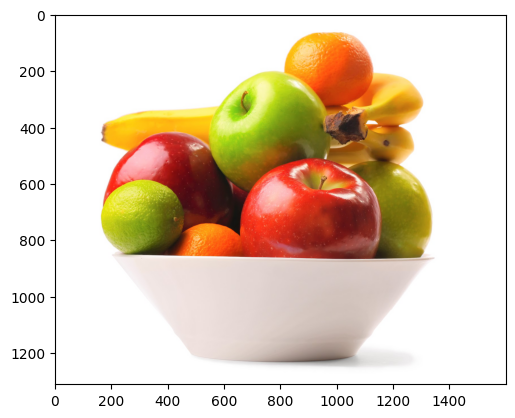

In [3]:
plt.imshow(image)

In [4]:
def to_pytorch1(img):
    img_t = torch.from_numpy(img)
    img_t = img_t.permute(2,0,1)
    img_t = img_t.unsqueeze(0)
    return img_t

In [5]:
img = to_pytorch1(image)
img2 = to_pytorch1(image2)

In [6]:
gray_img = kornia.color.rgb_to_grayscale(img)
gray_img2 = kornia.color.rgb_to_grayscale(img2)

In [7]:
def from_pytorch(img_t):
    img_t = img_t.squeeze(0)
    img_t = img_t.permute(1,2,0)
    img_t = img_t.numpy()
    return img_t

# CANNY EDGE DETECTION

## PART 1

In [8]:
def MyCanny(imag,sigma,threshold):
    kernel_size = int(sigma * 3) * 2 + 1 
    blurred_img = filters.gaussian_blur2d(imag, (kernel_size, kernel_size), (sigma, sigma))
    
    y_sobel = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).unsqueeze(0)
    x_sobel = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).unsqueeze(0)
    
    derivative_x = filters.filter2d(blurred_img, x_sobel)
    derivative_y = filters.filter2d(blurred_img, y_sobel)
    gradient_magnitude = torch.sqrt(torch.pow(derivative_x, 2) + torch.pow(derivative_y, 2))
    
    gradient_direction = torch.atan2(derivative_y, derivative_x)
    
    direction_45 = (torch.round(gradient_direction/(torch.pi/4)) % 4).long()
    
    padding = torch.nn.functional.pad(gradient_magnitude, (1, 1, 1, 1), mode='replicate').squeeze(0)
    
    magnitude_nms = torch.zeros_like(gradient_magnitude)
    for i in range(1, gradient_magnitude.shape[1]+1):
        for j in range(1, gradient_magnitude.shape[2]-1):
            value = gradient_direction[0,i-1,j-1]
            if torch.all(torch.eq(value, 0)):
                near = [padding[0,i-1,j], padding[0,i+1,j]]
            elif torch.all(torch.eq(value, torch.pi/4)):
                near = [padding[0,i-1,j-1], padding[0,i+1,j+1]]
            elif torch.all(torch.eq(value, torch.pi/2)):
                near = [padding[0,i,j-1], padding[0,i,j+1]]
            else:  
                near = [padding[0,i-1,j+1], padding[0,i+1,j-1]]
            if torch.all(gradient_magnitude[0,i-1,j-1] >= near[0]) and torch.all(gradient_magnitude[0,i-1,j-1] >= near[1]):
                magnitude_nms[0,i-1,j-1] = gradient_magnitude[0,i-1,j-1]
    desired_img = magnitude_nms > threshold
    
    return desired_img
    

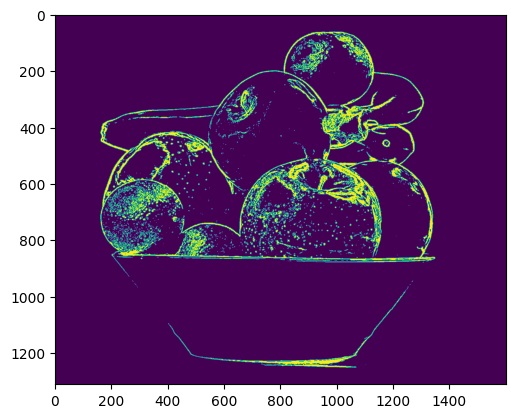

In [79]:
img1 = MyCanny(gray_img,0.7,0.13)
IMG1 = from_pytorch(img1)
plt.imshow(IMG1)

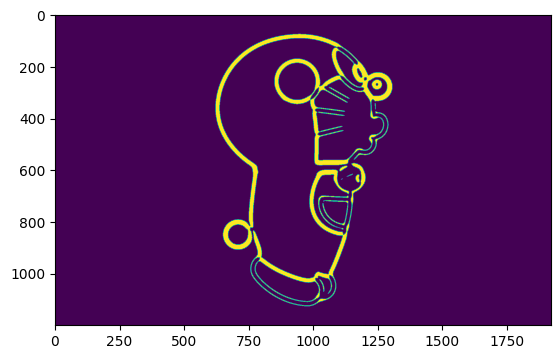

In [58]:
img4 = MyCanny(gray_img2,8,0.13)
IMG2 = from_pytorch(img4)
plt.imshow(IMG2)

## PART 2

In [80]:
def MyCannyFull(image,sigma,low_threshold, high_threshold):
    kernel_size = int(sigma * 3) * 2 + 1 
    blurred_img = filters.gaussian_blur2d(gray_img, (kernel_size, kernel_size), (sigma, sigma))
    
    x_sobel = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).unsqueeze(0)
    y_sobel = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).unsqueeze(0)
    
    derivative_x = filters.filter2d(blurred_img, x_sobel)
    derivative_y = filters.filter2d(blurred_img, y_sobel)
    gradient_magnitude = torch.sqrt(torch.pow(derivative_x, 2) + torch.pow(derivative_y, 2))
    
    gradient_direction = torch.atan2(derivative_y, derivative_x)
    
    direction_45 = (torch.round(gradient_direction/(torch.pi/4)) % 4).long()
    
    padding = torch.nn.functional.pad(gradient_magnitude, (1, 1, 1, 1), mode='replicate').squeeze(0)
    
    magnitude_nms = torch.zeros_like(gradient_magnitude)
    for i in range(1, gradient_magnitude.shape[1]+1):
        for j in range(1, gradient_magnitude.shape[2]-1):
            value = gradient_direction[0,i-1,j-1]
            if torch.all(torch.eq(value, 0)):
                near = [padding[0,i-1,j], padding[0,i+1,j]]
            elif torch.all(torch.eq(value, torch.pi/4)):
                near = [padding[0,i-1,j-1], padding[0,i+1,j+1]]
            elif torch.all(torch.eq(value, torch.pi/2)):
                near = [padding[0,i,j-1], padding[0,i,j+1]]
            else:  
                near = [padding[0,i-1,j+1], padding[0,i+1,j-1]]
            if torch.all(gradient_magnitude[0,i-1,j-1] >= near[0]) and torch.all(gradient_magnitude[0,i-1,j-1] >= near[1]):
                magnitude_nms[0,i-1,j-1] = gradient_magnitude[0,i-1,j-1]
    
    
    high_edges = (magnitude_nms > high_threshold).float()
    low_edges = ((magnitude_nms >= low_threshold) & (magnitude_nms <= high_threshold)).float()
    discovered_edges = torch.zeros_like(high_edges)
    
    queue = []
    for i in range(high_edges.shape[1]):
        for j in range(high_edges.shape[2]):
            if torch.all(high_edges[0,i,j] == 1) and torch.all(discovered_edges[0,i,j] == 0):
                queue.append((i,j))
                discovered_edges[0,i,j] = 1
    
    while queue:
        i, j = queue.pop(0)
        for ii in range(i-1, i+2):
            for jj in range(j-1, j+2):
                if ii >= 0 and ii < img.shape[1] and jj >= 0 and jj < img.shape[2]:
                    if (ii, jj) != (i, j) and discovered_edges[0,ii,jj] == 0 and low_edges[0,ii,jj] == 1:
                        discovered_edges[0,ii,jj] = 1
                        queue.append((ii,jj))
    
    desired_img = (high_edges + discovered_edges).clamp(max=1)
    
    return desired_img
    
    
    

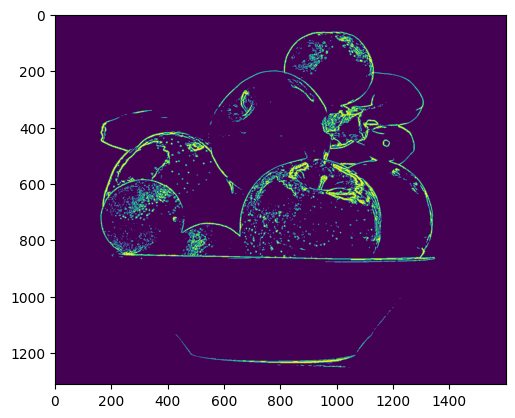

In [88]:
img1 = MyCannyFull(gray_img,0.7,0.13,0.2)
IMG1 = from_pytorch(img1)
plt.imshow(IMG1)

# SEAM CARVING